# Classification and Clustering Algorithms paired with Wine and Chocolate
------
<img src="images/datastaxlogo.png" width="200" height="200">

#### A demo using DataStax Enterprise Analytics, Apache Cassandra, Apache Spark, Python, Jupyter Notebooks, Twitter tweets, pattern, Kmeans and ...

#### Add some environment variables to find dse verision of pyspark. Edit these varibles with your path.

In [15]:
pysparkzip = "/Users/amanda.moran/dse67/dse-6.7.0/resources/spark/python/lib/pyspark.zip"
py4jzip = "/Users/amanda.moran/dse67/dse-6.7.0/resources/spark/python/lib/py4j-0.10.7-src.zip"

In [16]:
# Needed to be able to find pyspark libaries
import sys
sys.path.append(pysparkzip)
sys.path.append(py4jzip)

#### Import python packages -- all are required
##### Ignore any errors shown

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
import pandas
import cassandra
import pyspark
import re
import os
from uuid import uuid1
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

#### Helper function to have nicer formatting of Spark DataFrames

In [20]:
#Helper for pretty formatting for Spark DataFrames
def showDF(df, limitRows =  5, truncate = True):
    if(truncate):
        pandas.set_option('display.max_colwidth', 50)
    else:
        pandas.set_option('display.max_colwidth', -1)
    pandas.set_option('display.max_rows', limitRows)
    display(df.limit(limitRows).toPandas())
    pandas.reset_option('display.max_rows')

# DataStax Enterprise Analytics
<img src="images/datastaxlogo.png" width="200" height="200">

### Creating Tables and Loading Tables

#### Connect to DSE Analytics Cluster

In [21]:
from cassandra.cluster import Cluster

cluster = Cluster(['127.0.01'])
session = cluster.connect()

#### Create Demo Keyspace 

In [22]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS wineChocolate 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

#### Set keyspace 

In [23]:
session.set_keyspace('winechocolate')

In [24]:
query = "CREATE TABLE IF NOT EXISTS wine \
                                   (wineid int, cluster int, alcohol float, malic_acid float, \
                                   ash float, alcalinity_ash float, magnesium float, total_phenols float, \
                                   flavanoids float, nonflavanoid_phenols float, proanthocyains float, \
                                   color_intensity float, hue float, protein float, proline float, \
                                   PRIMARY KEY (wineId))"
session.execute(query)


### Load Wine Dataset
<img src="images/twitterlogo.png" width="100" height="100">

#### Load Negative Tweets from CSV file

In [25]:
fileName = 'data/wine.csv'
input_file = open(fileName, 'r')
i = 1
for line in input_file:
    wineId = i
    tweets = line.split(',')
    query = "INSERT INTO wine (wineid, cluster, alcohol, malic_acid, ash, alcalinity_ash, \
                               magnesium, total_phenols, flavanoids, nonflavanoid_phenols, \
                               proanthocyains, color_intensity, hue, protein, proline)"
    query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    session.execute(query, (wineId, int(tweets[0]), float(tweets[1]), float(tweets[2]), float(tweets[3]), 
                    float(tweets[4]), float(tweets[5]), float(tweets[6]), float(tweets[7]), float(tweets[8]),
                    float(tweets[9]), float(tweets[10]), float(tweets[11]), float(tweets[12]), float(tweets[13])))
    i = i + 1

#### Do a select * on each table and verify that the data have been inserted into each Apache Cassandra table

In [26]:
query = 'SELECT * FROM wine limit 2'
rows = session.execute(query)
for row in rows:
    print (row.wineid, row.cluster, row.alcohol, row.malic_acid, row.ash, row.alcalinity_ash,
           row.magnesium, row.total_phenols, row.flavanoids, row.nonflavanoid_phenols,
           row.proanthocyains, row.color_intensity, row.hue, row.protein, row.proline)

(23, 1, 13.710000038146973, 1.8600000143051147, 2.359999895095825, 16.600000381469727, 101.0, 2.609999895095825, 2.880000114440918, 0.27000001072883606, 1.690000057220459, 3.799999952316284, 1.1100000143051147, 4.0, 1035.0)
(114, 2, 11.40999984741211, 0.7400000095367432, 2.5, 21.0, 88.0, 2.4800000190734863, 2.009999990463257, 0.41999998688697815, 1.440000057220459, 3.0799999237060547, 1.100000023841858, 2.309999942779541, 434.0)


## DSE Analytics with Apache Spark
<img src="images/sparklogo.png" width="150" height="200">

### Finally time for Apache Spark! 

#### Create a spark session that is connected to Cassandra. From there load each table into a Spark Dataframe and take a count of the number of rows in each.

In [27]:
spark = SparkSession.builder.appName('demo').master("local").getOrCreate()


wineTable = spark.read.format("org.apache.spark.sql.cassandra").options(table="wine", keyspace="winechocolate").load()

print ("Table Row Count: ")
print (wineTable.count())

Table Row Count: 
178


In [28]:
showDF(wineTable)

,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60


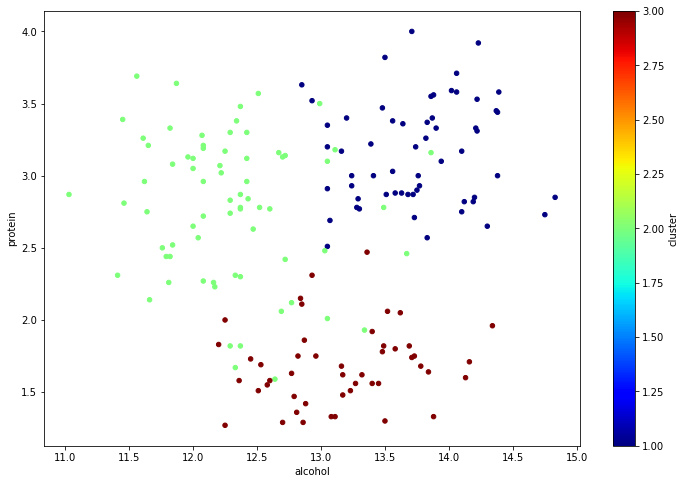

In [29]:
winedf = wineTable.toPandas()
winedf.plot.scatter(x = 'alcohol', y = 'protein', c= 'cluster', figsize=(12,8), colormap='jet')

In [30]:
newWineTable = wineTable[['alcalinity_ash', 'alcohol', 'ash', 
                          'color_intensity', 'protein', 'flavanoids', 'hue', 
                          'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                          'proline', 'total_phenols']]

In [31]:
#showDF(newWineTable)

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=['alcalinity_ash', 'alcohol', 'ash', 
               'color_intensity', 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                'proline', 'total_phenols'],
    outputCol='features')

trainingData = assembler.transform(newWineTable)
trainingData.show()

assembler = VectorAssembler(
    inputCols=[ 'alcalinity_ash', 'alcohol', 'ash', 
               'color_intensity', 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                'proline', 'total_phenols'],
    outputCol='features')

trainingData1 = assembler.transform(wineTable)
trainingData1.show()

+--------------+-------+----+---------------+-------+----------+----+---------+----------+--------------------+--------------+-------+-------------+--------------------+
|alcalinity_ash|alcohol| ash|color_intensity|protein|flavanoids| hue|magnesium|malic_acid|nonflavanoid_phenols|proanthocyains|proline|total_phenols|            features|
+--------------+-------+----+---------------+-------+----------+----+---------+----------+--------------------+--------------+-------+-------------+--------------------+
|          16.6|  13.71|2.36|            3.8|    4.0|      2.88|1.11|    101.0|      1.86|                0.27|          1.69| 1035.0|         2.61|[16.6000003814697...|
|          21.0|  11.41| 2.5|           3.08|   2.31|      2.01| 1.1|     88.0|      0.74|                0.42|          1.44|  434.0|         2.48|[21.0,11.40999984...|
|          14.0|  13.82|2.42|           7.05|   3.26|      3.74|1.01|    111.0|      1.75|                0.32|          1.87| 1190.0|         3.88|[1

In [79]:
from pyspark.ml.clustering import KMeans


kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData1)
centers = model.clusterCenters()
len(centers)

# Make predictions
predictions = model.transform(trainingData1)

showDF(predictions)

,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,4,16.799999,14.37,2.50,1,7.8,3.49,0.86,113.0,1.95,0.24,2.18,1480.0,3.45,3.85,"[16.799999237060547, 14.369999885559082, 2.5, ...",1
1,18,20.000000,13.83,2.62,1,6.6,3.40,1.13,115.0,1.57,0.40,1.72,1130.0,2.57,2.95,"[20.0, 13.829999923706055, 2.619999885559082, ...",1
2,177,20.000000,13.17,2.37,3,9.3,0.68,0.60,120.0,2.59,0.53,1.46,840.0,1.62,1.65,"[20.0, 13.170000076293945, 2.369999885559082, ...",2
3,51,12.400000,13.05,2.04,1,7.2,3.27,1.12,92.0,1.73,0.17,2.91,1150.0,2.91,2.72,"[12.399999618530273, 13.050000190734863, 2.039...",1
4,47,16.000000,14.38,2.28,1,4.9,3.17,1.04,102.0,3.59,0.27,2.19,1065.0,3.44,3.25,"[16.0, 14.380000114440918, 2.2799999713897705,...",2


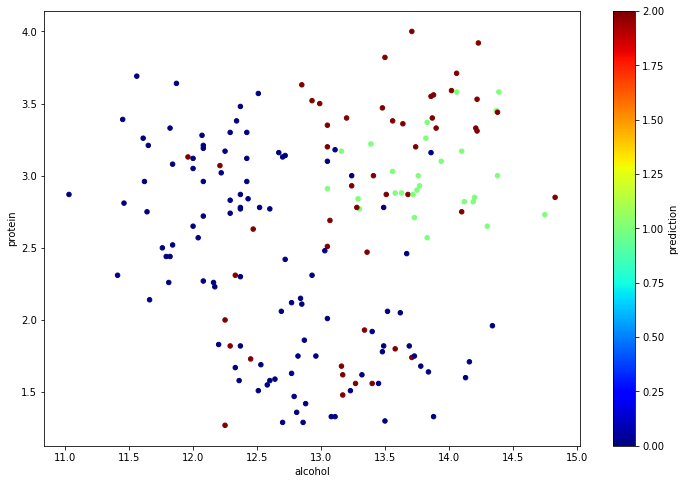

In [80]:
wine_df = predictions.toPandas()

wine_df.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

In [81]:
predictions.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   27|
|         2|   49|
|         0|  102|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



#### What do these column represent: 

* **Alcohol**: alcohol content, reported in units of ABV (alcohol by volume).

* **Malic acid**: one of the principal organic acids found in wine. Although found in nearly every fruit and berry, it’s flavor is most prominent in green apples; likewise, it projects this sour flavor into wine. For more information, feel free to read about acids in wine.

* **Ash**: yep, wine has ash in it. Ash is simply the inorganic matter left after evaporation and incineration.

* **Alcalinity of ash**: the alkalinity of ash determines how basic (as opposed to acidic) the ash in a wine is.

* **Magnesium**: magnesium is a metal that affects the flavor of wine.

* **Total phenols**: Phenols are chemicals that affect the taste, color, and mouthfeel (i.e., texture) of wine. For some (very) in-depth information about phenols, we refer you to phenolic content in wine.

* **Flavoids** : flavonoids are a type of phenol.

* **Nonflavoid phenols**: nonflavonoids are another type of phenol.

* **Proanthocyanins**: proanthocyanidins are yet another type of phenol.

* **Color intensity**: the color intensity of a wine: i.e., how dark it is.

* **Hue**: the hue of a wine, which is typically determined by the color of the cultivar used (although this is not always the case).

* **OD280/OD315 of diluted wines**: protein content measurements. --Renamed to protein 

* **Proline**: an amino acid present in wines.

Reference: https://cs.brown.edu/courses/cs100/homework/homework-3-part-ii/

### Let's remove any column that we think is an external factor that would effect the wine but the plant
* Alcohol
* Ash
* Alcalinity of Ash
* Color intensity -- but we will keep hue as the hue is determined by the type of cultivar used

In [82]:
assembler = VectorAssembler(
    inputCols=[ 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid', 'nonflavanoid_phenols', 'proanthocyains', 
                'proline', 'total_phenols'],
    outputCol='features')

trainingData0 = assembler.transform(wineTable)

In [83]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData0)
centers = model.clusterCenters()
len(centers)

# Make predictions
predictions0 = model.transform(trainingData0)

showDF(predictions0)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,156,22.0,13.17,2.32,3,7.900000,0.63,0.60,93.0,5.19,0.61,1.55,725.0,1.48,1.74,"[1.4800000190734863, 0.6299999952316284, 0.600...",0
1,81,19.0,12.00,2.00,2,2.500000,2.26,1.38,86.0,0.92,0.30,1.43,278.0,3.12,2.42,"[3.119999885559082, 2.259999990463257, 1.37999...",2
2,29,19.4,13.87,2.80,1,4.500000,2.97,1.25,107.0,1.90,0.37,1.76,915.0,3.40,2.95,"[3.4000000953674316, 2.9700000286102295, 1.25,...",0
3,172,19.5,12.77,2.28,3,9.899999,0.51,0.57,86.0,2.39,0.48,0.64,470.0,1.63,1.39,"[1.6299999952316284, 0.5099999904632568, 0.569...",2
4,64,19.0,12.37,2.16,2,4.450000,3.10,1.22,87.0,1.13,0.19,1.87,420.0,2.87,3.50,"[2.869999885559082, 3.0999999046325684, 1.2200...",2


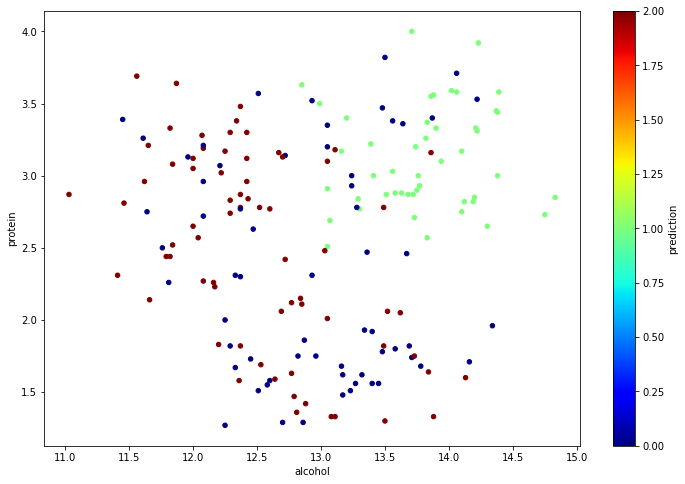

In [84]:
wine_df0 = predictions0.toPandas()

wine_df0.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

In [60]:
predictions0.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   47|
|         2|   62|
|         0|   69|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



In [86]:
assembler = VectorAssembler(
    inputCols=[ 'protein', 'flavanoids', 'hue', 
                'magnesium', 'malic_acid'],
    outputCol='features')

trainingData2 = assembler.transform(wineTable)

In [87]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData2)
centers = model.clusterCenters()
len(centers)

# Make predictions
predictions2 = model.transform(trainingData2)

showDF(predictions2)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61,"[4.0, 2.880000114440918, 1.1100000143051147, 1...",2
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48,"[2.309999942779541, 2.009999990463257, 1.10000...",0
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88,"[3.259999990463257, 3.740000009536743, 1.00999...",2
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74,"[3.259999990463257, 2.9200000762939453, 0.9599...",0
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60,"[2.2699999809265137, 1.5, 1.0800000429153442, ...",0


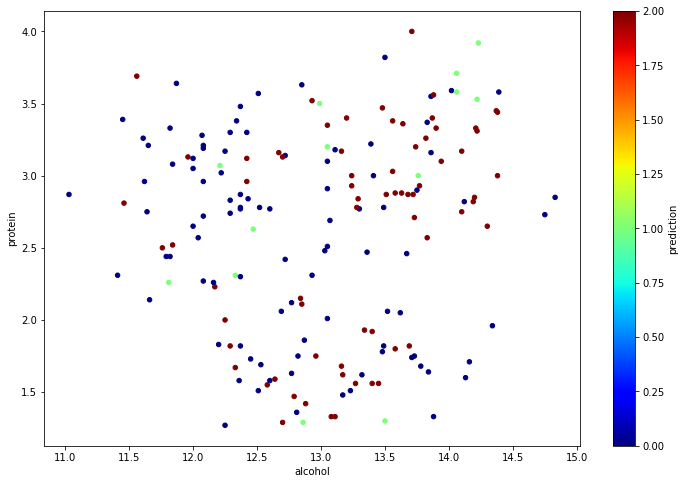

In [88]:
wine_df2 = predictions2.toPandas()

wine_df2.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

In [89]:
predictions2.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   13|
|         2|   69|
|         0|   96|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



In [90]:
assembler = VectorAssembler(
    inputCols=['alcohol', 'protein'],
    outputCol='features')

trainingData3 = assembler.transform(wineTable)

In [91]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(trainingData3)
centers = model.clusterCenters()
len(centers)

# Make predictions
predictions3 = model.transform(trainingData3)

showDF(predictions3)


,wineid,alcalinity_ash,alcohol,ash,cluster,color_intensity,flavanoids,hue,magnesium,malic_acid,nonflavanoid_phenols,proanthocyains,proline,protein,total_phenols,features,prediction
0,23,16.6,13.71,2.36,1,3.80,2.88,1.11,101.0,1.86,0.27,1.69,1035.0,4.00,2.61,"[13.710000038146973, 4.0]",1
1,114,21.0,11.41,2.50,2,3.08,2.01,1.10,88.0,0.74,0.42,1.44,434.0,2.31,2.48,"[11.40999984741211, 2.309999942779541]",0
2,53,14.0,13.82,2.42,1,7.05,3.74,1.01,111.0,1.75,0.32,1.87,1190.0,3.26,3.88,"[13.819999694824219, 3.259999990463257]",1
3,110,20.0,11.61,2.70,2,2.65,2.92,0.96,94.0,1.35,0.29,2.49,680.0,3.26,2.74,"[11.609999656677246, 3.259999990463257]",0
4,91,18.5,12.08,2.32,2,2.40,1.50,1.08,81.0,1.83,0.52,1.64,480.0,2.27,1.60,"[12.079999923706055, 2.2699999809265137]",0


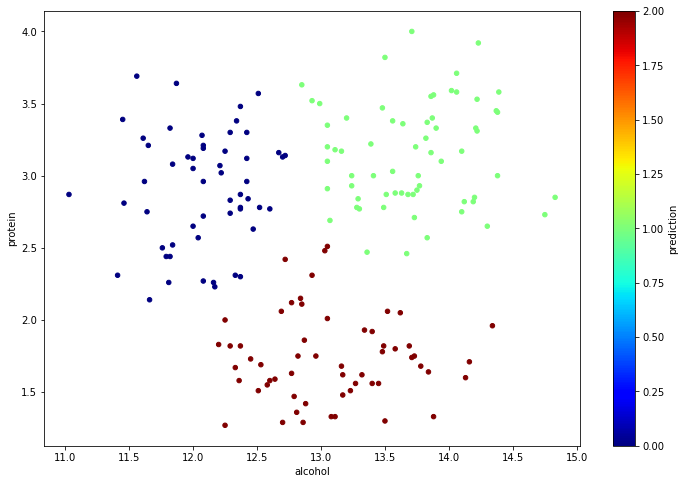

In [92]:
wine_df3 = predictions3.toPandas()

wine_df3.plot.scatter(x = 'alcohol', y = 'protein', c= 'prediction', figsize=(12,8), colormap='jet')

In [93]:
predictions3.groupBy('prediction').count().show()
wineTable.groupBy('cluster').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   65|
|         2|   58|
|         0|   55|
+----------+-----+

+-------+-----+
|cluster|count|
+-------+-----+
|      1|   59|
|      3|   48|
|      2|   71|
+-------+-----+



In [14]:
session.execute("""drop table wine""")

References: 
* https://sweetcode.io/k-means-clustering-python/ 

* https://cs.brown.edu/courses/cs100/homework/homework-3-part-ii/